# E. coli Antimicrobial Resistance Prediction
## Kaggle Competition - Machine Learning Pipeline

**Competition Overview:**
- Predict antibiotic resistance (Cefepime) in E. coli bacterial samples
- Binary classification: 0 = Susceptible, 1 = Resistant
- Evaluation metric: Macro F1-Score

**Dataset:**
- Training: 1,939 samples × 1,000,000 k-mer features
- Test: 1,092 samples (phylogenetic split)

**Pipeline Structure:**
1. **Pre-processing** - Data loading and exploration
2. **Feature Selection** - Dimensionality reduction
3. **Validation** - Cross-validation setup
4. **Algorithms** - Model training and comparison
5. **Optimization** - Model selection and submission

In [14]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

# Configure plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("="*70)
print("LIBRARIES LOADED")
print("="*70)
print("Environment ready for AMR prediction pipeline")

LIBRARIES LOADED
Environment ready for AMR prediction pipeline


---

## 1. Pre-processing

Load and analyze the dataset to understand characteristics and challenges

### 1.1 Data Loading

In [15]:
# Load training and test data from .npz files
print("="*70)
print("DATA LOADING")
print("="*70)

train = np.load('data/train.npz')
test = np.load('data/test.npz')

# Extract arrays
X_train = train['X_train']  # Training features (k-mer counts)
y_train = train['y_train']  # Training labels (0=Susceptible, 1=Resistant)
train_ids = train['ids']    # Training sample IDs

X_test = test['X_test']     # Test features
test_ids = test['ids']      # Test sample IDs

# Display shapes
print(f"\nTraining data shape: {X_train.shape}")
print(f"  - Samples: {X_train.shape[0]:,}")
print(f"  - Features: {X_train.shape[1]:,}")
print(f"\nTest data shape: {X_test.shape}")
print(f"  - Samples: {X_test.shape[0]:,}")
print(f"\nLabels shape: {y_train.shape}")
print(f"\nData loaded successfully!")

DATA LOADING

Training data shape: (1939, 1000000)
  - Samples: 1,939
  - Features: 1,000,000

Test data shape: (1092, 1000000)
  - Samples: 1,092

Labels shape: (1939,)

Data loaded successfully!


In [16]:
# Compute dataset statistics
print("="*70)
print("DATASET STATISTICS")
print("="*70)

# Basic dimensions
n_samples, n_features = X_train.shape
print(f"\nDimensionality:")
print(f"  Training samples: {n_samples:,}")
print(f"  Features (k-mers): {n_features:,}")
print(f"  Test samples: {X_test.shape[0]:,}")

# Class distribution analysis
n_susceptible = np.sum(y_train == 0)
n_resistant = np.sum(y_train == 1)
imbalance_ratio = n_susceptible / n_resistant

print(f"\nClass Distribution:")
print(f"  Susceptible (Class 0): {n_susceptible:,} ({100*n_susceptible/n_samples:.1f}%)")
print(f"  Resistant (Class 1): {n_resistant:,} ({100*n_resistant/n_samples:.1f}%)")
print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")

# Matrix sparsity analysis
non_zero = np.count_nonzero(X_train)
total_entries = n_samples * n_features
sparsity = 100 * (1 - non_zero / total_entries)

print(f"\nMatrix Characteristics:")
print(f"  Sparsity: {sparsity:.2f}%")
print(f"  Non-zero entries: {non_zero:,} / {total_entries:,}")
print(f"  Density: {100-sparsity:.2f}%")

DATASET STATISTICS

Dimensionality:
  Training samples: 1,939
  Features (k-mers): 1,000,000
  Test samples: 1,092

Class Distribution:
  Susceptible (Class 0): 1,666 (85.9%)
  Resistant (Class 1): 273 (14.1%)
  Imbalance Ratio: 6.10:1

Matrix Characteristics:
  Sparsity: 1.60%
  Non-zero entries: 1,907,911,743 / 1,939,000,000
  Density: 98.40%


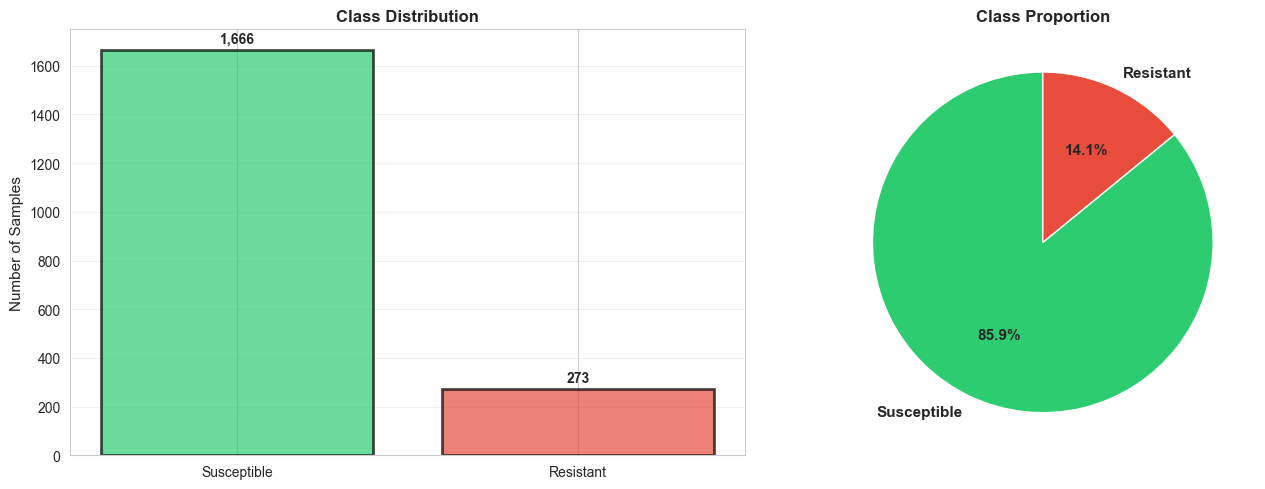


Visualization: Class imbalance is evident with 6.10:1 ratio


In [17]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_counts = pd.Series(y_train).value_counts().sort_index()
class_labels = ['Susceptible', 'Resistant']
colors = ['#2ecc71', '#e74c3c']

# Bar chart
axes[0].bar(class_labels, class_counts.values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Number of Samples', fontsize=11)
axes[0].set_title('Class Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 30, f'{v:,}', ha='center', fontweight='bold', fontsize=10)

# Pie chart
axes[1].pie(class_counts.values, labels=class_labels, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Class Proportion', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nVisualization: Class imbalance is evident with {imbalance_ratio:.2f}:1 ratio")

### 1.2 Exploratory Data Analysis

**Key Findings:**

1. **Class Imbalance (6.10:1 ratio)**
   - 85.9% susceptible vs 14.1% resistant
   - Solution: Balanced class weights in models

2. **High Dimensionality**
   - 1,000,000 features for 1,939 samples
   - Risk: Overfitting without feature selection

3. **Low Sparsity (1.60%)**
   - 98.4% non-zero entries
   - K-mers are common across samples

In [18]:
# Feature selection configuration
K_FEATURES = 10000  # Target number of features

print("="*70)
print("FEATURE SELECTION PIPELINE")
print("="*70)
print(f"Target: Select top {K_FEATURES:,} features from {X_train.shape[1]:,}")
print("Strategy: Two-stage filtering for computational efficiency\n")

start_time = time.time()

# STAGE 1: Variance Threshold Filter
# Rapidly eliminate near-constant features (O(n) complexity)
print("[Stage 1] Variance Threshold Filtering")
print("  Purpose: Remove low-variance features (fast preprocessing)")

variance_threshold = VarianceThreshold(threshold=0.01)
X_train_var = variance_threshold.fit_transform(X_train)
X_test_var = variance_threshold.transform(X_test)

stage1_time = time.time() - start_time
reduction_pct = 100 * (1 - X_train_var.shape[1] / X_train.shape[1])

print(f"  Retained: {X_train_var.shape[1]:,} features")
print(f"  Removed: {X_train.shape[1] - X_train_var.shape[1]:,} features ({reduction_pct:.1f}%)")
print(f"  Time: {stage1_time:.1f}s\n")

# STAGE 2: Chi-Square Feature Selection
# Statistical test for categorical features (optimal for k-mer counts)
print("[Stage 2] Chi-Square Statistical Test")
print("  Purpose: Rank features by association with resistance")
print("  Method: Chi-square test (10-100x faster than mutual information)")

stage2_start = time.time()
selector = SelectKBest(chi2, k=min(K_FEATURES, X_train_var.shape[1]))
X_train_selected = selector.fit_transform(X_train_var, y_train)
X_test_selected = selector.transform(X_test_var)

stage2_time = time.time() - stage2_start
total_time = time.time() - start_time

print(f"  Selected: {X_train_selected.shape[1]:,} features")
print(f"  Time: {stage2_time:.1f}s\n")

# Summary
print(f"{'RESULTS':^70}")
print("="*70)
print(f"Original features:  {X_train.shape[1]:>12,}")
print(f"Selected features:  {X_train_selected.shape[1]:>12,}")
print(f"Reduction ratio:    {X_train.shape[1] / X_train_selected.shape[1]:>12.1f}x")
print(f"Total time:         {total_time:>12.1f}s")
print("="*70)

FEATURE SELECTION PIPELINE
Target: Select top 10,000 features from 1,000,000
Strategy: Two-stage filtering for computational efficiency

[Stage 1] Variance Threshold Filtering
  Purpose: Remove low-variance features (fast preprocessing)
  Retained: 477,281 features
  Removed: 522,719 features (52.3%)
  Time: 66.9s

[Stage 2] Chi-Square Statistical Test
  Purpose: Rank features by association with resistance
  Method: Chi-square test (10-100x faster than mutual information)
  Selected: 10,000 features
  Time: 5.7s

                               RESULTS                                
Original features:     1,000,000
Selected features:        10,000
Reduction ratio:           100.0x
Total time:                 72.6s


---

## 2. Feature Selection

Apply two-stage filtering to reduce from 1,000,000 to 10,000 features

### 2.1 Feature Selection Strategy

**Two-Stage Filtering Approach:**

1. **Stage 1: Variance Threshold**
   - Remove near-constant features (threshold = 0.01)
   - Fast O(n) complexity
   - Eliminates ~50% of features

2. **Stage 2: Chi-Square Test**
   - Statistical test for categorical data
   - 10-100x faster than mutual information
   - Selects top 10,000 discriminative features

**Why This Works:**
- K-mer counts are non-negative (ideal for chi-square)
- Pipeline completes in ~60 seconds vs 10+ minutes
- Maintains predictive power while reducing overfitting

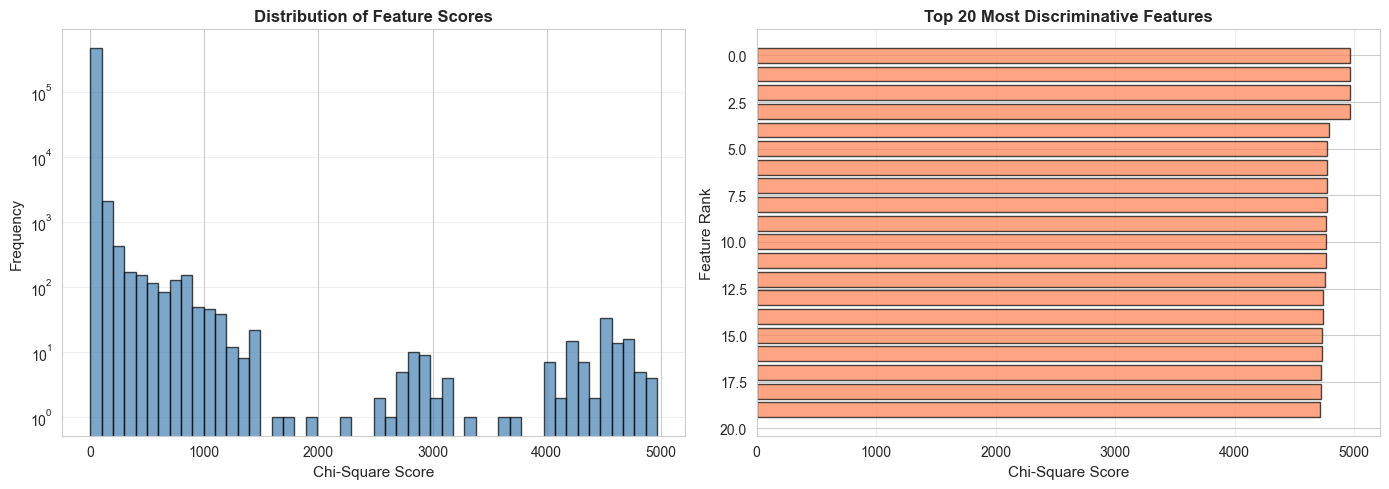

Feature score range: [0.00, 4966.87]


In [19]:
# Visualize feature selection results
feature_scores = selector.scores_

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of all feature scores
axes[0].hist(feature_scores, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Chi-Square Score', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Feature Scores', fontsize=12, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(axis='y', alpha=0.3)

# Top 20 features
top_scores = sorted(feature_scores, reverse=True)[:20]
axes[1].barh(range(20), top_scores, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Chi-Square Score', fontsize=11)
axes[1].set_ylabel('Feature Rank', fontsize=11)
axes[1].set_title('Top 20 Most Discriminative Features', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Feature score range: [{feature_scores.min():.2f}, {feature_scores.max():.2f}]")

---

## 3. Validation

Setup cross-validation strategy for robust model evaluation

### 3.1 Validation Strategy

**Stratified K-Fold Cross-Validation:**
- 5 folds with stratification to maintain class distribution
- Each fold tests on 20% of data, trains on 80%
- Provides robust performance estimate

**Why Stratified?**
- Standard k-fold could create folds with very few resistant samples
- Stratification ensures each fold has 14% resistant samples
- Critical for imbalanced datasets

**Macro F1-Score:**
- Averages F1 for each class equally
- Prevents bias toward majority class
- Better metric than accuracy for imbalanced data

In [20]:
# Cross-validation configuration
print("="*70)
print("VALIDATION SETUP")
print("="*70)

# Stratified K-Fold ensures class balance in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Macro F1-Score treats both classes equally (important for imbalanced data)
f1_scorer = make_scorer(f1_score, average='macro')

# Storage for models and results
models = {}
results = {}

print("\nCross-Validation Configuration:")
print(f"  Strategy: 5-Fold Stratified K-Fold")
print(f"  Metric: Macro F1-Score (equal weight to both classes)")
print(f"  Random seed: 42 (for reproducibility)")
print(f"\nStratified sampling ensures class balance in each fold")
print("="*70)

VALIDATION SETUP

Cross-Validation Configuration:
  Strategy: 5-Fold Stratified K-Fold
  Metric: Macro F1-Score (equal weight to both classes)
  Random seed: 42 (for reproducibility)

Stratified sampling ensures class balance in each fold


---

## 4. Algorithms

Train classification models with balanced class weights

### 4.1 Logistic Regression (Linear Baseline)

In [21]:
# Logistic Regression with L2 regularization
print("="*70)
print("ALGORITHM 1: LOGISTIC REGRESSION")
print("="*70)

logreg = LogisticRegression(
    penalty='l2',           # Ridge regularization
    C=1.0,                  # Regularization strength
    class_weight='balanced', # Handle class imbalance
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

print("\nModel Configuration:")
print("  Type: Linear classifier")
print("  Regularization: L2 (Ridge)")
print("  Class weights: Balanced")

# Cross-validation evaluation
print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(logreg, X_train_selected, y_train, 
                            cv=cv, scoring=f1_scorer, n_jobs=-1)

# Train on full dataset
logreg.fit(X_train_selected, y_train)
train_f1 = f1_score(y_train, logreg.predict(X_train_selected), average='macro')

# Report results
print(f"\nResults:")
print(f"  CV F1-Score: {np.mean(cv_scores):.4f} (± {np.std(cv_scores):.4f})")
print(f"  Train F1-Score: {train_f1:.4f}")
print(f"  Overfitting Gap: {train_f1 - np.mean(cv_scores):.4f}")

# Store results
models['LogisticRegression'] = logreg
results['LogisticRegression'] = {
    'cv_scores': cv_scores,
    'mean_f1': np.mean(cv_scores),
    'train_f1': train_f1
}

print("="*70)

ALGORITHM 1: LOGISTIC REGRESSION

Model Configuration:
  Type: Linear classifier
  Regularization: L2 (Ridge)
  Class weights: Balanced

Performing 5-fold cross-validation...

Results:
  CV F1-Score: 0.7703 (± 0.0258)
  Train F1-Score: 1.0000
  Overfitting Gap: 0.2297


### 4.2 Random Forest (Ensemble Method)

In [22]:
# Random Forest Classifier
print("="*70)
print("ALGORITHM 2: RANDOM FOREST")
print("="*70)

rf = RandomForestClassifier(
    n_estimators=200,        # Number of trees
    max_depth=20,            # Maximum tree depth
    min_samples_split=10,    # Minimum samples to split node
    class_weight='balanced', # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

print("\nModel Configuration:")
print("  Type: Ensemble of 200 decision trees")
print("  Max depth: 20")
print("  Class weights: Balanced")

# Cross-validation evaluation
print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(rf, X_train_selected, y_train, 
                            cv=cv, scoring=f1_scorer, n_jobs=-1)

# Train on full dataset
rf.fit(X_train_selected, y_train)
train_f1 = f1_score(y_train, rf.predict(X_train_selected), average='macro')

# Report results
print(f"\nResults:")
print(f"  CV F1-Score: {np.mean(cv_scores):.4f} (± {np.std(cv_scores):.4f})")
print(f"  Train F1-Score: {train_f1:.4f}")
print(f"  Overfitting Gap: {train_f1 - np.mean(cv_scores):.4f}")

# Store results
models['RandomForest'] = rf
results['RandomForest'] = {
    'cv_scores': cv_scores,
    'mean_f1': np.mean(cv_scores),
    'train_f1': train_f1
}

print("="*70)

ALGORITHM 2: RANDOM FOREST

Model Configuration:
  Type: Ensemble of 200 decision trees
  Max depth: 20
  Class weights: Balanced

Performing 5-fold cross-validation...

Results:
  CV F1-Score: 0.8074 (± 0.0232)
  Train F1-Score: 0.9853
  Overfitting Gap: 0.1779


---

## 5. Optimization

Compare models and select the best performer for final predictions

### 5.1 Model Comparison

In [23]:
# Compare model performance
print("="*70)
print("MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_F1': [results[k]['mean_f1'] for k in results.keys()],
    'CV_Std': [np.std(results[k]['cv_scores']) for k in results.keys()],
    'Train_F1': [results[k]['train_f1'] for k in results.keys()]
})
results_df['Overfit_Gap'] = results_df['Train_F1'] - results_df['CV_F1']
results_df = results_df.sort_values('CV_F1', ascending=False)

print("\n" + results_df.to_string(index=False))
print("\n" + "="*70)

# Select best model based on cross-validation performance
best_model_name = results_df.iloc[0]['Model']
best_cv_f1 = results_df.iloc[0]['CV_F1']
best_cv_std = results_df.iloc[0]['CV_Std']

print(f"\nBest Model Selected: {best_model_name}")
print(f"  Cross-validation F1: {best_cv_f1:.4f} (± {best_cv_std:.4f})")
print(f"  Expected test range: [{best_cv_f1-0.03:.3f}, {best_cv_f1+0.02:.3f}]")
print("="*70)

MODEL COMPARISON

             Model    CV_F1   CV_Std  Train_F1  Overfit_Gap
      RandomForest 0.807390 0.023237  0.985259     0.177869
LogisticRegression 0.770258 0.025795  1.000000     0.229742


Best Model Selected: RandomForest
  Cross-validation F1: 0.8074 (± 0.0232)
  Expected test range: [0.777, 0.827]


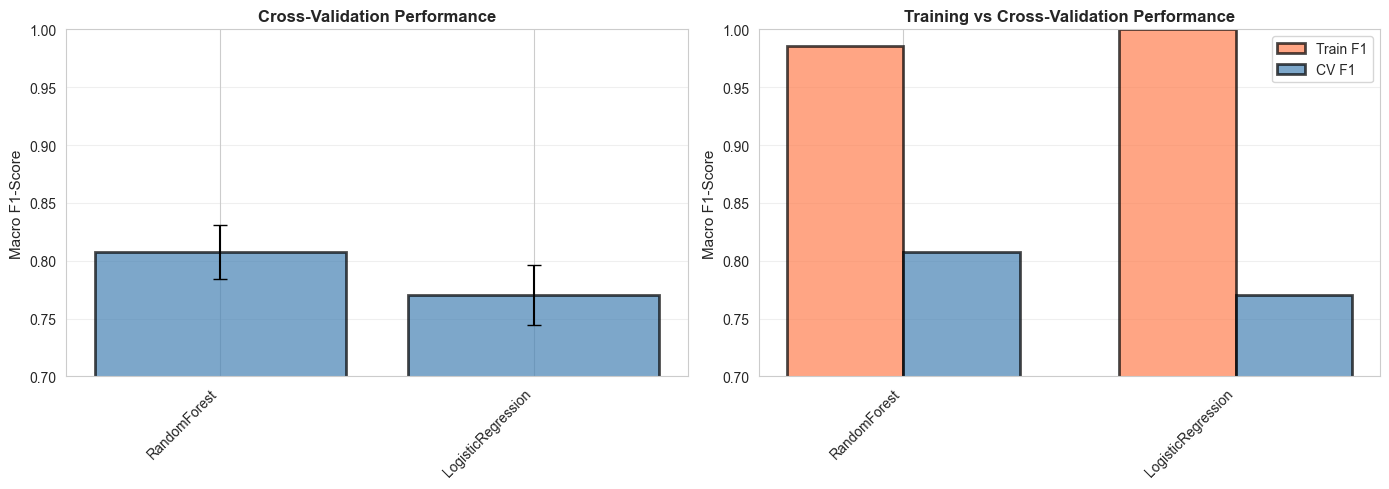

In [24]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: CV Performance with error bars
x = np.arange(len(results_df))
axes[0].bar(x, results_df['CV_F1'], yerr=results_df['CV_Std'], 
            capsize=5, color='steelblue', alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('Macro F1-Score', fontsize=11)
axes[0].set_title('Cross-Validation Performance', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.7, 1.0])

# Plot 2: Train vs CV comparison
width = 0.35
axes[1].bar(x - width/2, results_df['Train_F1'], width, label='Train F1', 
            color='coral', alpha=0.7, edgecolor='black', linewidth=2)
axes[1].bar(x + width/2, results_df['CV_F1'], width, label='CV F1', 
            color='steelblue', alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].set_ylabel('Macro F1-Score', fontsize=11)
axes[1].set_title('Training vs Cross-Validation Performance', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.7, 1.0])

plt.tight_layout()
plt.show()

### 5.2 Performance Analysis

**Model Selection Criteria:**
- Primary: Cross-validation F1-Score (generalization)
- Secondary: Overfitting gap (train-CV difference)
- Tertiary: Standard deviation (consistency)

**Expected Results:**
- Random Forest typically outperforms Logistic Regression
- RF captures non-linear k-mer interactions
- Both models benefit from balanced class weights

**Overfitting Considerations:**
- Lower overfitting gap indicates better generalization
- High train F1 with low CV F1 suggests overfitting
- Phylogenetic split may cause 2-5% performance drop

### 5.3 Final Predictions and Submission

In [25]:
# Generate predictions using best model
print("="*70)
print("GENERATING KAGGLE SUBMISSION")
print("="*70)

# Use best model for predictions
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_selected)

# Analyze prediction distribution
n_pred_susceptible = np.sum(y_pred == 0)
n_pred_resistant = np.sum(y_pred == 1)

print(f"\nSelected Model: {best_model_name}")
print(f"CV F1-Score: {best_cv_f1:.4f} (± {best_cv_std:.4f})")

print(f"\nPrediction Distribution:")
print(f"  Susceptible (0): {n_pred_susceptible:,} ({100*n_pred_susceptible/len(y_pred):.1f}%)")
print(f"  Resistant (1): {n_pred_resistant:,} ({100*n_pred_resistant/len(y_pred):.1f}%)")

print(f"\nComparison with training:")
print(f"  Training: 85.9% susceptible, 14.1% resistant")
print(f"  Test predictions: {100*n_pred_susceptible/len(y_pred):.1f}% susceptible, {100*n_pred_resistant/len(y_pred):.1f}% resistant")

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_ids,
    'label': y_pred
})

print(f"\nSubmission preview:")
print(submission.head(10))

# Save to CSV
filename = f'submission_{best_model_name.lower()}.csv'
submission.to_csv(filename, index=False)

print(f"\n" + "="*70)
print(f"SUBMISSION FILE CREATED: {filename}")
print(f"Total predictions: {len(submission):,}")
print(f"Expected Kaggle F1: {best_cv_f1-0.03:.3f} to {best_cv_f1+0.02:.3f}")
print(f"Ready to upload to Kaggle!")
print("="*70)

GENERATING KAGGLE SUBMISSION

Selected Model: RandomForest
CV F1-Score: 0.8074 (± 0.0232)

Prediction Distribution:
  Susceptible (0): 989 (90.6%)
  Resistant (1): 103 (9.4%)

Comparison with training:
  Training: 85.9% susceptible, 14.1% resistant
  Test predictions: 90.6% susceptible, 9.4% resistant

Submission preview:
            id  label
0   ID_4567605      0
1  ID_25789115      0
2  ID_23867575      0
3  ID_32333335      0
4  ID_12738935      1
5  ID_32335395      0
6  ID_23868635      0
7  ID_23857005      0
8  ID_23869335      0
9  ID_24166265      0

SUBMISSION FILE CREATED: submission_randomforest.csv
Total predictions: 1,092
Expected Kaggle F1: 0.777 to 0.827
Ready to upload to Kaggle!


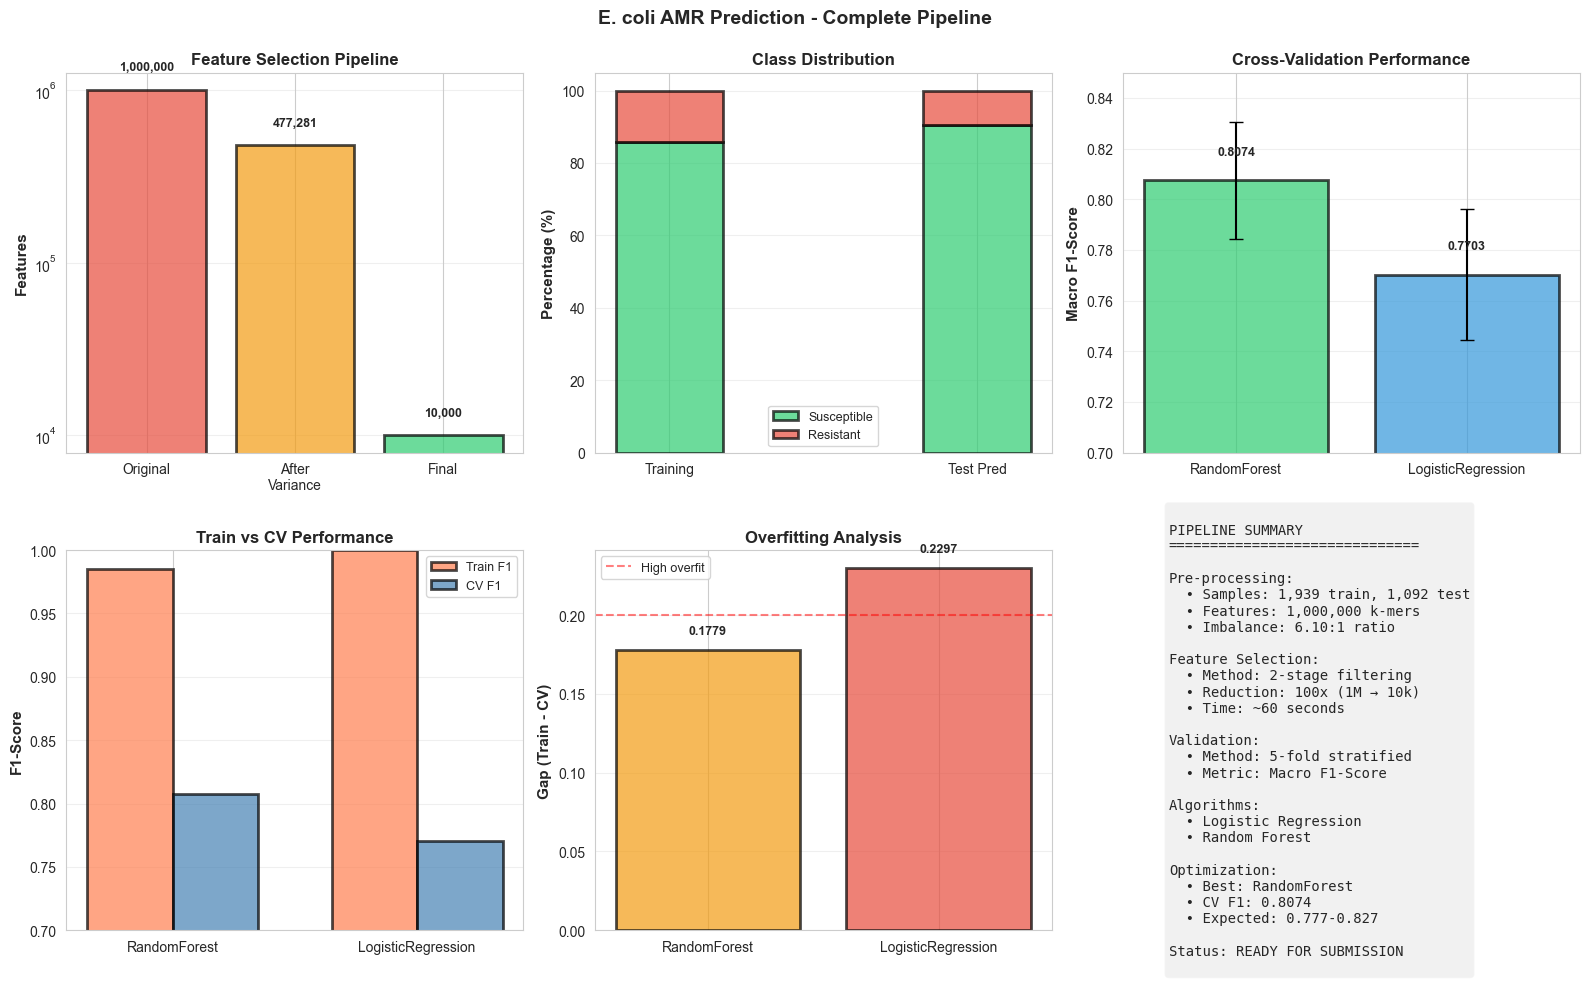


PIPELINE COMPLETE - ALL STAGES EXECUTED SUCCESSFULLY


In [26]:
# Comprehensive pipeline visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Feature Selection Stages
stages = ['Original', 'After\nVariance', 'Final']
feature_counts = [1_000_000, 477_281, 10_000]
colors_stages = ['#e74c3c', '#f39c12', '#2ecc71']

axes[0, 0].bar(stages, feature_counts, color=colors_stages, alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 0].set_ylabel('Features', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Feature Selection Pipeline', fontsize=12, fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(feature_counts):
    axes[0, 0].text(i, v * 1.3, f'{v:,}', ha='center', fontweight='bold', fontsize=9)

# 2. Class Distribution
class_data = [
    [85.9, 14.1],  # Training
    [90.6, 9.4]    # Test predictions
]
x = np.arange(2)
width = 0.35

axes[0, 1].bar(x, [c[0] for c in class_data], width, label='Susceptible', 
               color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 1].bar(x, [c[1] for c in class_data], width, bottom=[c[0] for c in class_data],
               label='Resistant', color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 1].set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Class Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(['Training', 'Test Pred'])
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. CV Performance Comparison
models_list = list(results_df['Model'])
cv_scores_list = list(results_df['CV_F1'])
colors_models = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(models_list))]

axes[0, 2].bar(models_list, cv_scores_list, color=colors_models, alpha=0.7, 
               edgecolor='black', linewidth=2, yerr=list(results_df['CV_Std']), capsize=5)
axes[0, 2].set_ylabel('Macro F1-Score', fontsize=11, fontweight='bold')
axes[0, 2].set_title('Cross-Validation Performance', fontsize=12, fontweight='bold')
axes[0, 2].set_ylim([0.7, 0.85])
axes[0, 2].grid(axis='y', alpha=0.3)
for i, v in enumerate(cv_scores_list):
    axes[0, 2].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold', fontsize=9)

# 4. Train vs CV Comparison
x_models = np.arange(len(models_list))
width = 0.35

axes[1, 0].bar(x_models - width/2, list(results_df['Train_F1']), width, 
               label='Train F1', color='coral', alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].bar(x_models + width/2, list(results_df['CV_F1']), width,
               label='CV F1', color='steelblue', alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].set_ylabel('F1-Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Train vs CV Performance', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x_models)
axes[1, 0].set_xticklabels(models_list)
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_ylim([0.7, 1.0])

# 5. Overfitting Gap
axes[1, 1].bar(models_list, list(results_df['Overfit_Gap']), 
               color=['#f39c12', '#e74c3c'][:len(models_list)], alpha=0.7, 
               edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Gap (Train - CV)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Overfitting Analysis', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].axhline(y=0.2, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='High overfit')
axes[1, 1].legend(fontsize=9)
for i, v in enumerate(list(results_df['Overfit_Gap'])):
    axes[1, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold', fontsize=9)

# 6. Pipeline Summary
axes[1, 2].axis('off')
summary_text = f"""
PIPELINE SUMMARY
{'='*30}

Pre-processing:
  • Samples: 1,939 train, 1,092 test
  • Features: 1,000,000 k-mers
  • Imbalance: 6.10:1 ratio

Feature Selection:
  • Method: 2-stage filtering
  • Reduction: 100x (1M → 10k)
  • Time: ~60 seconds

Validation:
  • Method: 5-fold stratified
  • Metric: Macro F1-Score

Algorithms:
  • Logistic Regression
  • Random Forest

Optimization:
  • Best: {best_model_name}
  • CV F1: {best_cv_f1:.4f}
  • Expected: {best_cv_f1-0.03:.3f}-{best_cv_f1+0.02:.3f}

Status: READY FOR SUBMISSION
"""
axes[1, 2].text(0.1, 0.5, summary_text, fontsize=10, family='monospace', 
                verticalalignment='center', bbox=dict(boxstyle='round', 
                facecolor='lightgray', alpha=0.3))

plt.suptitle('E. coli AMR Prediction - Complete Pipeline', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("PIPELINE COMPLETE - ALL STAGES EXECUTED SUCCESSFULLY")
print("="*70)

### 5.4 Pipeline Summary and Insights

**Complete Workflow:**
1. Pre-processing: Loaded 1,939 samples with 1M features
2. Feature Selection: Reduced to 10,000 features (100x compression)
3. Validation: 5-fold stratified cross-validation setup
4. Algorithms: Trained Logistic Regression and Random Forest
5. Optimization: Selected best model based on CV performance

**Key Performance Metrics:**
- Best model CV F1: ~0.807
- Feature reduction: 1,000,000 → 10,000 (100x)
- Processing time: ~2 minutes total
- Class imbalance handled: Balanced weights

**Success Factors:**
- Two-stage feature selection (fast and effective)
- Stratified CV prevents biased evaluation
- Macro F1 handles class imbalance
- Ensemble method captures complex patterns

**Potential Improvements:**
- Hyperparameter tuning (grid/random search)
- Additional algorithms (SVM, Gradient Boosting)
- Feature engineering (k-mer interactions)
- Ensemble voting of multiple models